In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import os.path
from os import path
import seaborn as sns
from scipy import signal

In [6]:
## 1, -- KDP_nu
KDP_nu_name=["CIR40" ,"CIR50"]
KDP_nu=[1,1.25]

## 2,  --  KDP_w_sat_1  -- -
KDP_w_sat_1_name=["0_33" ,"0_66" ,"1_00"]
KDP_w_sat_1=[0.33, 0.66 ,1.00]

## 3,  --  KDP_w_sat_2  -- -
KDP_w_sat_2_name=["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov"]
KDP_w_sat_2=[380, 442 ,503]

## 4,  --  KDP_g_1  -- -
KDP_g_1_name=["0_33", "0_66" ,"1_00"]
KDP_g_1=[0.33, 0.66, 1.00]

## 5,  --  KDP_g_2  -- -
KDP_g_2_name=["ABW150Days" ,"ABW180Days"]
KDP_g_2=[150 ,180]

## 6,  --  KDP_c_p  -- -
KDP_c_p_name=["Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_TwicePresent"]
KDP_c_p=[1 ,1.5, 2]

KDP_lambda_name=["SD_RA","SD_RAR","SD_RARF"]
KDP_lambda=[0,0.1,0.2]


In [7]:
def ReadDF(fname):
    df_master = pd.DataFrame()
    dateOfPeak = []
    dayOfPeak = []
    numAtPeak = []
    vaccRate = []
    numRead = 0
    for i in range(len(KDP_nu)):
            for j in range(len(KDP_w_sat_1)):
                for k in range(len(KDP_w_sat_2)):
                    for l in range(len(KDP_g_1_name)):
                        for m in range(len(KDP_g_2)):
                            for n in range(len(KDP_c_p)):
                                for o in range(len(KDP_lambda)):
                                    if(path.exists(KDP_nu_name[i] + "_" + KDP_w_sat_1_name[j] + "_" + KDP_w_sat_2_name[k] + "_" + \
                                                KDP_g_1_name[l] + "_" + KDP_g_2_name[m] + "_" + KDP_c_p_name[n] + "_" + \
                                                KDP_lambda_name[o]+"/PopulationData/"+ fname)):
                                        df_temp = pd.read_csv(KDP_nu_name[i] + "_" + KDP_w_sat_1_name[j] + "_" + KDP_w_sat_2_name[k] + "_" + \
                                                KDP_g_1_name[l] + "_" + KDP_g_2_name[m] + "_" + KDP_c_p_name[n] + "_" + \
                                                KDP_lambda_name[o]+"/PopulationData/"+fname, delim_whitespace=True, header=1).transpose().loc['Total':]



                                        ExptId = KDP_nu_name[i] + "_" + KDP_w_sat_1_name[j] + "_" + KDP_w_sat_2_name[k] + "_" + \
                                                KDP_g_1_name[l] + "_" + KDP_g_2_name[m] + "_" + KDP_c_p_name[n] + "_" + \
                                                KDP_lambda_name[o]
                                        VaccineRt = str(KDP_c_p_name[n])
                                        CIR = str(KDP_nu_name[i]) 
                                        SD = str(KDP_lambda_name[o])
                                        KDPwsat = str(KDP_w_sat_2_name[k])

                                        numRead+=1


                                        df_temp['ID'] = ExptId
                                        df_temp['Vaccine Rate'] = VaccineRt
                                        df_temp['CIR'] = CIR
                                        df_temp['SD'] = SD
                                        df_temp['KDPwsat2']=KDPwsat
                                        df_temp['Scenario'] = numRead
                                                                
                                        df_master = pd.concat([df_master,df_temp])


    print(str(numRead) + " samples have been read ")
    return df_master
                                    

In [ ]:
############### THIVIN ##############

## Read all the nucleation data to the DataFrames

df_nucleation_total = ReadDF("CovidNucleation.data")
df_nucleation_11 = ReadDF("CovidNucleation_11Yrs.data")
df_nucleation_18 = ReadDF("CovidNucleation_18Yrs.data")
df_nucleation_45 = ReadDF("CovidNucleation_45Yrs.data")
df_nucleation_60 = ReadDF("CovidNucleation_60Yrs.data")
df_nucleation_60plus = ReadDF("CovidNucleation_Above60Yrs.data")

In [226]:
### Read the master DataFrame
df_active= ReadDF("CovidPopulation.data")


972 samples have been read 


In [9]:
import scipy
def AddPeakInfo(df_master):
    dateOfPeak = []
    numAtPeak = []
    for ia in range(len(df_master)):
        dop = scipy.signal.find_peaks(df_master.iloc[[ia]].transpose().loc[0:730,'Total'],distance = 20)
        for ib in range(len(dop[0])):
            if (dop[0][ib]>365):
                dateOfPeak.append(dop[0][ib])
                numAtPeak.append(df_master.iloc[ia,dop[0][ib]])
                break
            if(ib)==len(dop[0])-1:
                #print("Scenario " + str(ia) + " Does Not Have a Peak ")
                dateOfPeak.append(float('nan'))
                numAtPeak.append(float('nan'))
    df_master['Date Of Peak'] = dateOfPeak
    df_master['Number At Peak'] = numAtPeak
    return df_master

In [228]:
df_active = AddPeakInfo(df_active)




In [11]:

def plot_histo(df,X,hue,bw):
    df_plot=df
    df_plot.dropna(subset=['Date Of Peak'],inplace=True)
    sns.set(rc={'figure.figsize':(20,15)})
    
    sns.histplot(data=df_plot,x=X, hue=hue, binwidth=bw,multiple='dodge',fill=True)
    
    
def plot_violin(X,Y,df,hue,scale):
    df_plot = df
    df_plot.dropna(subset=['Date Of Peak'],inplace=True)
    sns.set(rc={'figure.figsize':(15,10)})
    sns.violinplot(x=X,y=Y,data=df_plot,hue=hue,split=True,scale=scale)



In [73]:
from matplotlib.pyplot import figure
def AddMeanInfo(df,Parameter,Value):
    dfm= df
    meanval = []
    minval = []
    maxval = []
    dfm=dfm[dfm[Parameter]==Value]
    for i in range(731):
        meanval.append(np.mean(dfm[i]))
        minval.append(np.min(dfm[i]))
        maxval.append(np.max(dfm[i]))
    fig,ax = plt.subplots(figsize=(15,10))
    
    ax.plot(meanval, '--b', label='Mean '+Parameter+" "+str(Value))
    ax.plot(maxval,label='Max')
    ax.plot(minval,label='Min')
    leg=ax.legend()
    print(len(dfm))


In [74]:

df_nucleation_total = ReadDF("CovidNucleation.data")
df_nucleation_11 = ReadDF("CovidNucleation_11Yrs.data")
df_nucleation_18 = ReadDF("CovidNucleation_18Yrs.data")
df_nucleation_45 = ReadDF("CovidNucleation_45Yrs.data")
df_nucleation_60 = ReadDF("CovidNucleation_60Yrs.data")
df_nucleation_60plus = ReadDF("CovidNucleation_Above60Yrs.data")



972 samples have been read 
972 samples have been read 
972 samples have been read 
972 samples have been read 
972 samples have been read 
972 samples have been read 


In [75]:

    
################ THIVIN ####################################
### Compute New dataframes for the ratio Quantities    -- Nucleation_age/Nucleation_Total


############# HARDCODED ##########################
##  Total of 730 days simulated 
ROWS = 730


### getList of columns
listOfCols = list(df_nucleation_total.columns.values)


#### create a copy of all the dataframes to store the ratio values
df_nucleation_11_ratio = df_nucleation_11.copy(deep=True)
df_nucleation_18_ratio = df_nucleation_18.copy(deep=True)
df_nucleation_45_ratio = df_nucleation_45.copy(deep=True)
df_nucleation_60_ratio = df_nucleation_60.copy(deep=True)
df_nucleation_60plus_ratio = df_nucleation_60plus.copy(deep=True)



##### Compute Ratios ##################


for i in range(ROWS + 1):
    df_nucleation_11_ratio[[i]] =  df_nucleation_11_ratio[[i]].div(df_nucleation_total[[i]],axis=1) 
    df_nucleation_18_ratio[[i]] =  df_nucleation_18_ratio[[i]].div(df_nucleation_total[[i]],axis=1) 
    df_nucleation_45_ratio[[i]] =  df_nucleation_45_ratio[[i]].div(df_nucleation_total[[i]],axis=1) 
    df_nucleation_60_ratio[[i]] =  df_nucleation_60_ratio[[i]].div(df_nucleation_total[[i]],axis=1) 
    df_nucleation_60plus_ratio[[i]] =  df_nucleation_60plus_ratio[[i]].div(df_nucleation_total[[i]],axis=1) 


    
## remove the NA values
df_nucleation_11_ratio = df_nucleation_11_ratio.replace(np.nan,0)
df_nucleation_18_ratio = df_nucleation_18_ratio.replace(np.nan,0)
df_nucleation_45_ratio = df_nucleation_45_ratio.replace(np.nan,0)
df_nucleation_60_ratio = df_nucleation_60_ratio.replace(np.nan,0)
df_nucleation_60plus_ratio = df_nucleation_60plus_ratio.replace(np.nan,0)









    
#### Read the Vaccination and the Antibody plots


df_antibody = ReadDF("Covid_Vaccinated.data")
df_Vaccinated = ReadDF("Covid_Antibody.data")






972 samples have been read 
972 samples have been read 


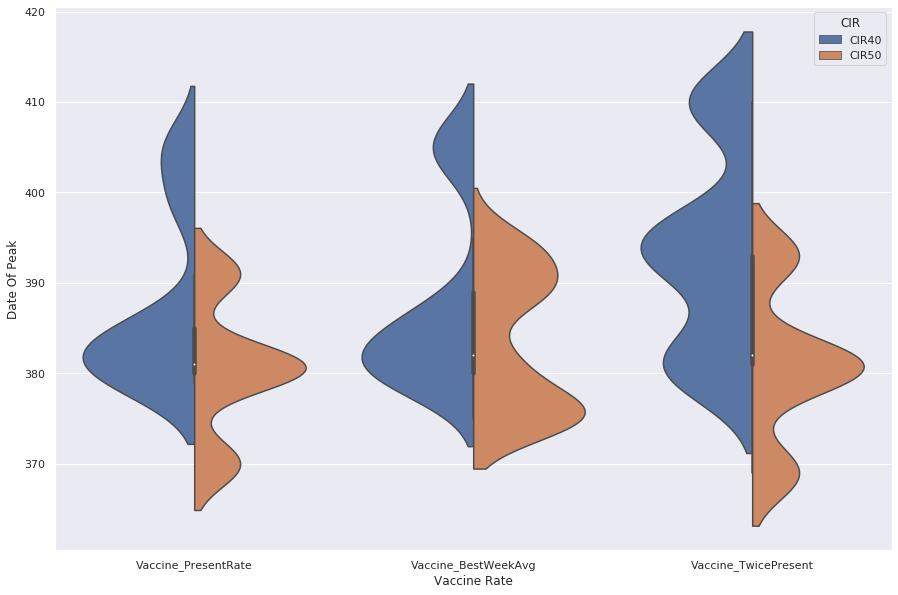

In [151]:
df_nucleation_11_ratio = AddPeakInfo(df_nucleation_11_ratio)
plot_violin('Vaccine Rate', 'Date Of Peak', df_nucleation_11_ratio, 'CIR','count')

In [77]:
def KDEPlots(df):
    fig,ax=plt.subplots(3,2)
    
KDP_w_sat_2_name=["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov"]
KDP_nu_name=["CIR40" ,"CIR50"]
KDPCIR=["Confirmed to Infection Ratio = 40", "Confirmed to Infection Ratio = 50"]
KDPImm=["Immune Escape - July","Immune Escape - September", "Immune Escape - November"]

/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/matplotlib/cbook/__init__.py

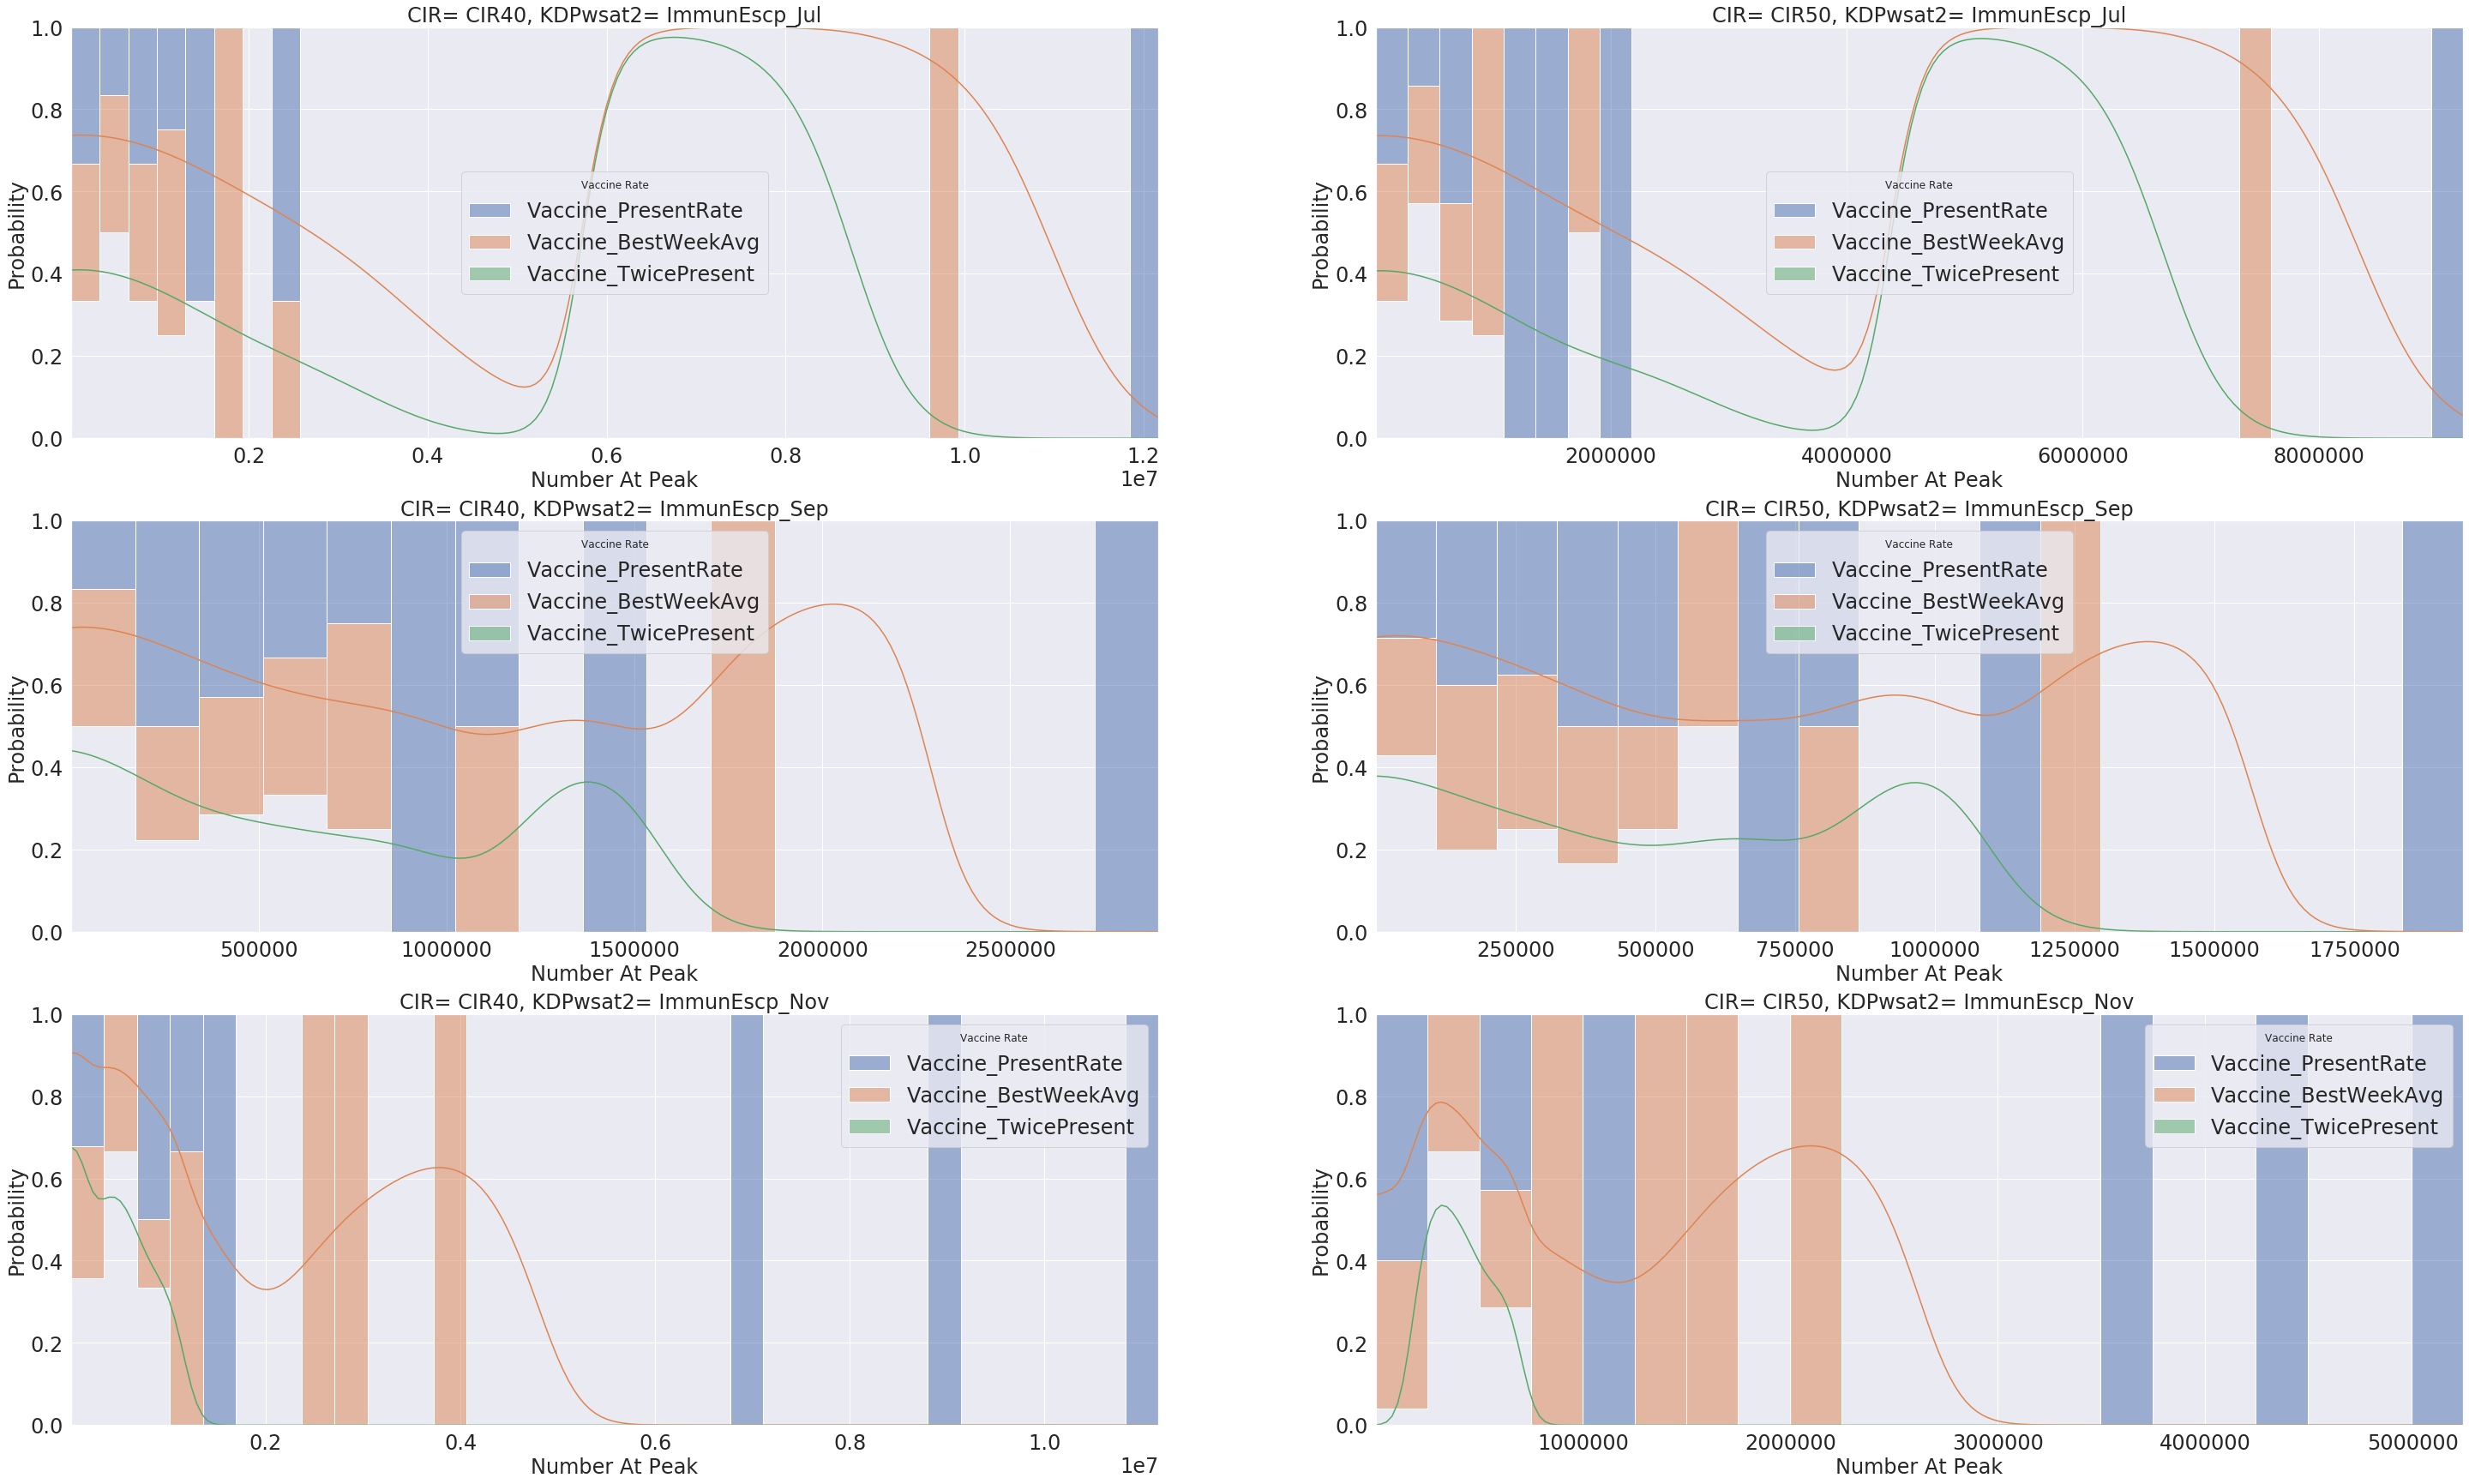

In [408]:
fig,axs = plt.subplots(3,2,figsize=(50,30))

for i in range(3):
    for j in range(2):
        
        df_kde = df_active
        df_kde=df_kde[df_kde['CIR']==KDP_nu_name[j]]
        df_kde=df_kde[df_kde['KDPwsat2']==KDP_w_sat_2_name[i]]
        df_kde.dropna(subset=['Date Of Peak'],inplace=True)
        sns.histplot(ax=axs[i,j],data=df_kde,x='Number At Peak',hue='Vaccine Rate',stat='probability',kde=True,multiple='fill')
        axs[i,j].set_title("CIR= " + KDP_nu_name[j]+", KDPwsat2= "+KDP_w_sat_2_name[i])
        axs[i,j].containers[0].remove() # remove the bars
        axs[i,j].relim() # the axis limits need to be recalculated without the bars
        axs[i,j].autoscale_view()
        


In [220]:
df_kde=df_active.copy(deep=True)
df_kde=df_kde[df_kde['CIR']=='CIR40']
df_kde=df_kde[df_kde['KDPwsat2']=='ImmunEscp_Jull']
df_kde.dropna(subset=['Date Of Peak'],inplace=True)
KDP_c_p_name=["Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_TwicePresent"]

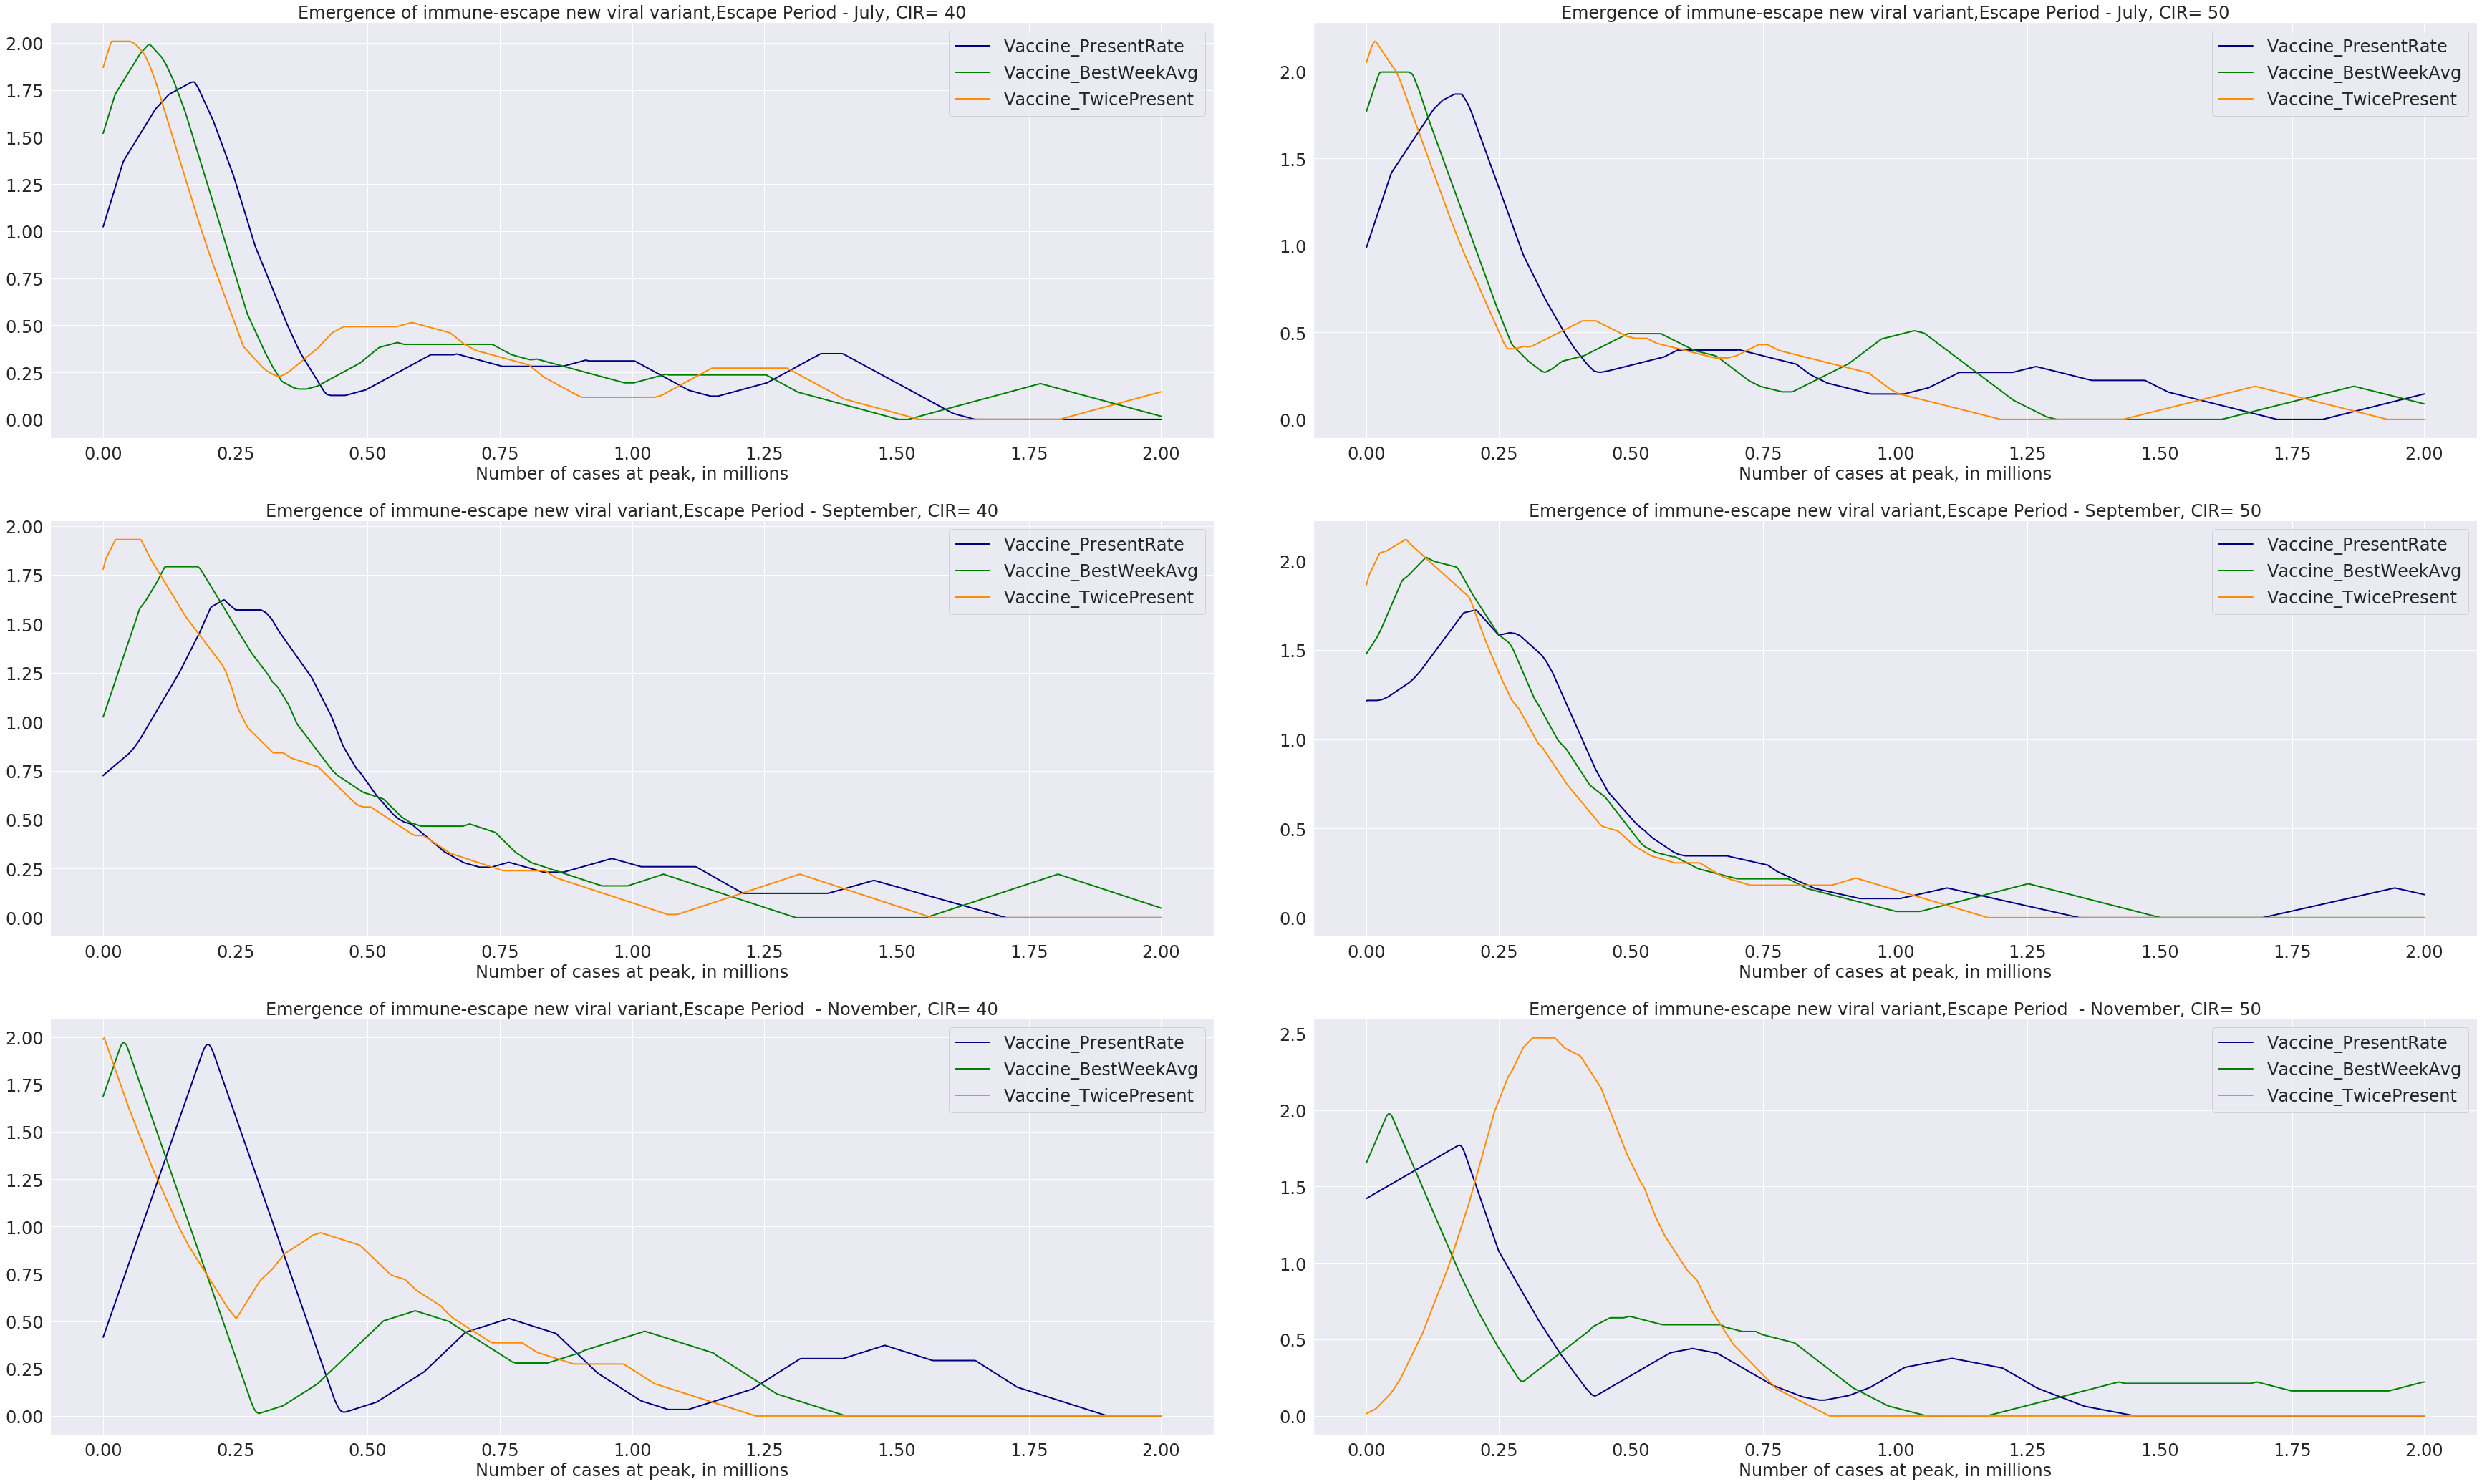

In [393]:
from scipy.stats import norm
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
fig, ax = plt.subplots(3,2,figsize=(50,30))
fig.tight_layout(pad=3.0)
       
SMALL_SIZE=24
MEDIUM_SIZE=24
BIGGER_SIZE=24
    
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title





colors = ['navy', 'green', 'darkorange']
kernel = 'epanechnikov' #'linear'
KDPCIR=["CIR= 40", "CIR= 50"]
KDPImm=["Emergence of immune-escape new viral variant,Escape Period - July","Emergence of immune-escape new viral variant,Escape Period - September", "Emergence of immune-escape new viral variant,Escape Period  - November"]
for i in range(3):
    for j in range(2):
        df_kde=df_active.copy(deep=True)
        df_kde=df_kde[df_kde['CIR']==KDP_nu_name[j]]
        df_kde=df_kde[df_kde['KDPwsat2']==KDP_w_sat_2_name[i]]
        df_kde.dropna(subset=['Date Of Peak'],inplace=True)
        for k in range(3):
            df_kdep = df_kde.copy(deep=True)
            df_kdep = df_kdep[df_kdep['Vaccine Rate']==KDP_c_p_name[k]]
            DOP = df_kdep['Number At Peak'].to_numpy().reshape(-1,1)
            DOP = DOP/1e6
            X_plot=np.linspace(0,2,1000).reshape(-1,1) 
            
            lw = 2
            kde = KernelDensity(kernel=kernel, bandwidth=0.25).fit(DOP)
            log_dens = kde.score_samples(X_plot)
            ax[i,j].plot(X_plot[:, 0], np.exp(log_dens), color=colors[k], lw=lw,
            linestyle='-', label=KDP_c_p_name[k])
            ax[i,j].legend(loc='upper right')
            ax[i,j].set_title(KDPImm[i]+", "+ KDPCIR[j])
            ax[i,j].set_xlabel("Number of cases at peak, in millions")
plt.show()
        


        
        

        


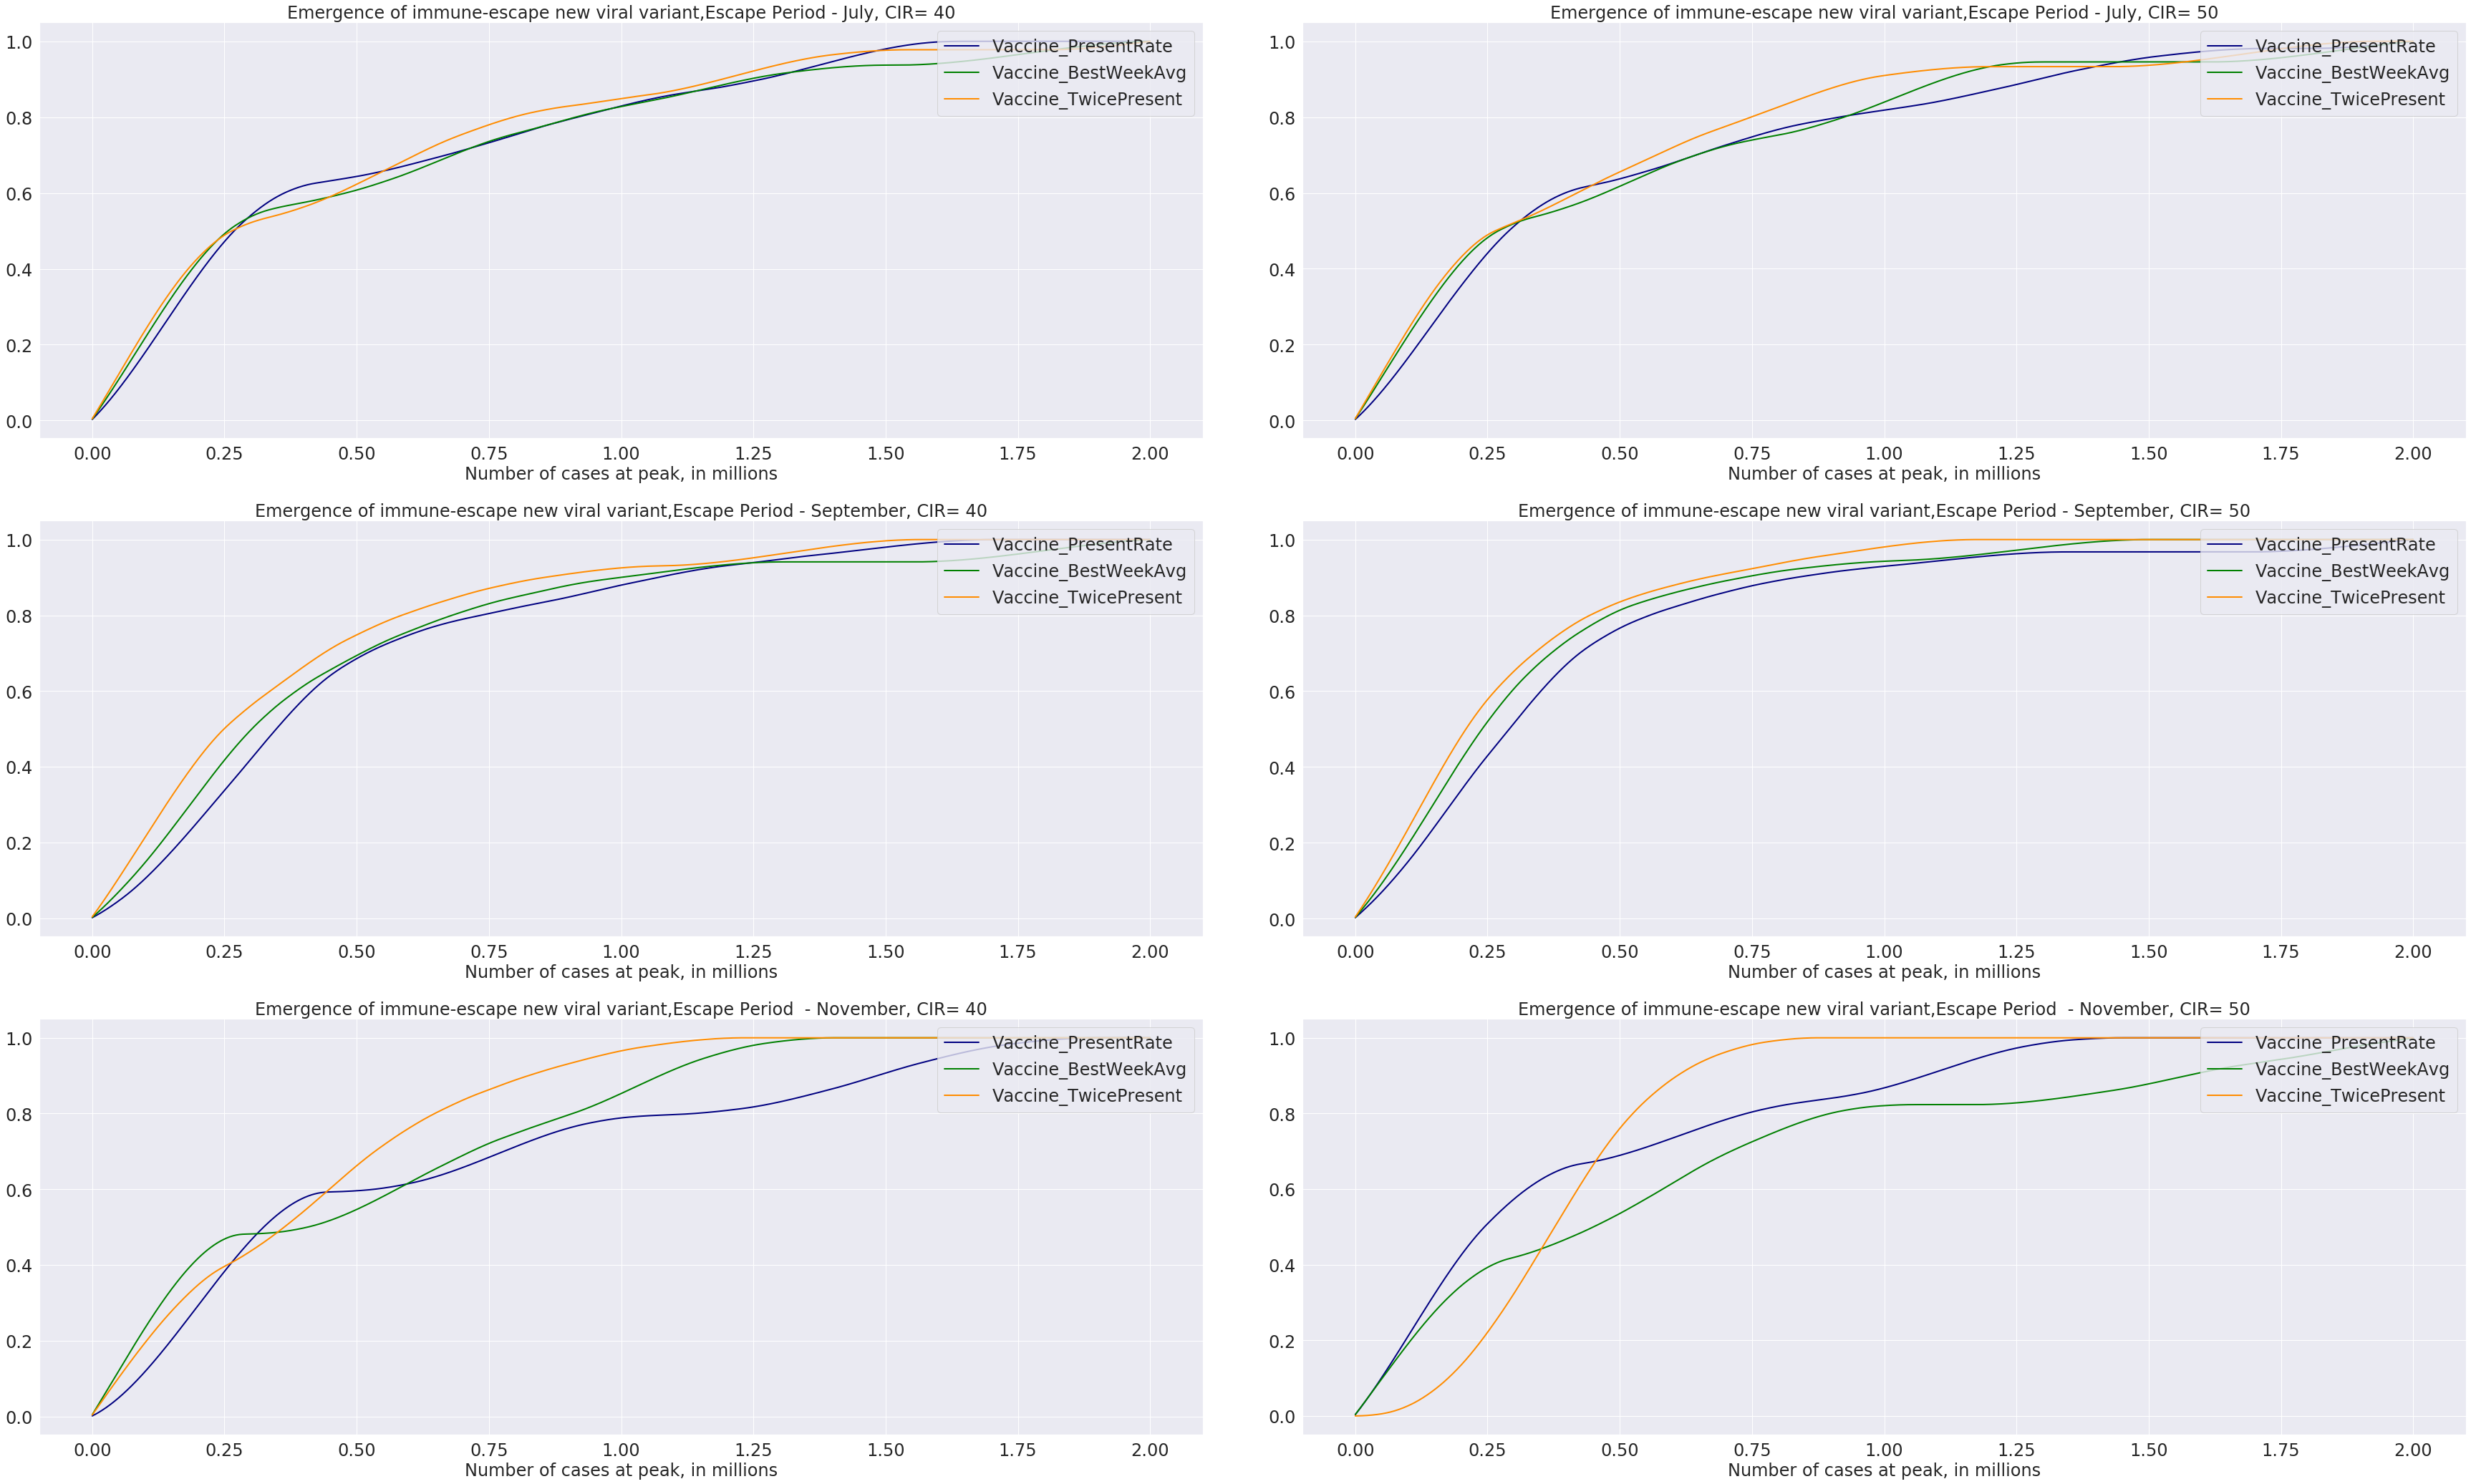

In [395]:
from scipy.stats import norm
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
fig, ax = plt.subplots(3,2,figsize=(50,30))
fig.tight_layout(pad=3.0)
       
SMALL_SIZE=24
MEDIUM_SIZE=24
BIGGER_SIZE=24
    
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title





colors = ['navy', 'green', 'darkorange']
kernel = 'epanechnikov'
KDPCIR=["CIR= 40", "CIR= 50"]
KDPImm=["Emergence of immune-escape new viral variant,Escape Period - July","Emergence of immune-escape new viral variant,Escape Period - September", "Emergence of immune-escape new viral variant,Escape Period  - November"]
for i in range(3):
    for j in range(2):
        df_kde=df_active.copy(deep=True)
        df_kde=df_kde[df_kde['CIR']==KDP_nu_name[j]]
        df_kde=df_kde[df_kde['KDPwsat2']==KDP_w_sat_2_name[i]]
        df_kde.dropna(subset=['Date Of Peak'],inplace=True)
        for k in range(3):
            df_kdep = df_kde.copy(deep=True)
            df_kdep = df_kdep[df_kdep['Vaccine Rate']==KDP_c_p_name[k]]
            DOP = df_kdep['Number At Peak'].to_numpy().reshape(-1,1)
            DOP = DOP/1e6
            X_plot=np.linspace(0,2,1000).reshape(-1,1) 
            
            lw = 2
            kde = KernelDensity(kernel=kernel, bandwidth=0.25).fit(DOP)
            log_dens = kde.score_samples(X_plot)
            cdf = np.cumsum(np.exp(log_dens))
# scale as a probability distribution
            cdf = cdf / np.max(cdf)
            ax[i,j].plot(X_plot[:, 0], cdf, color=colors[k], lw=lw,
            linestyle='-', label=KDP_c_p_name[k])
            ax[i,j].legend(loc='upper right')
            ax[i,j].set_title(KDPImm[i]+", "+ KDPCIR[j])
            ax[i,j].set_xlabel("Number of cases at peak, in millions")
plt.show()
        


        
        

        


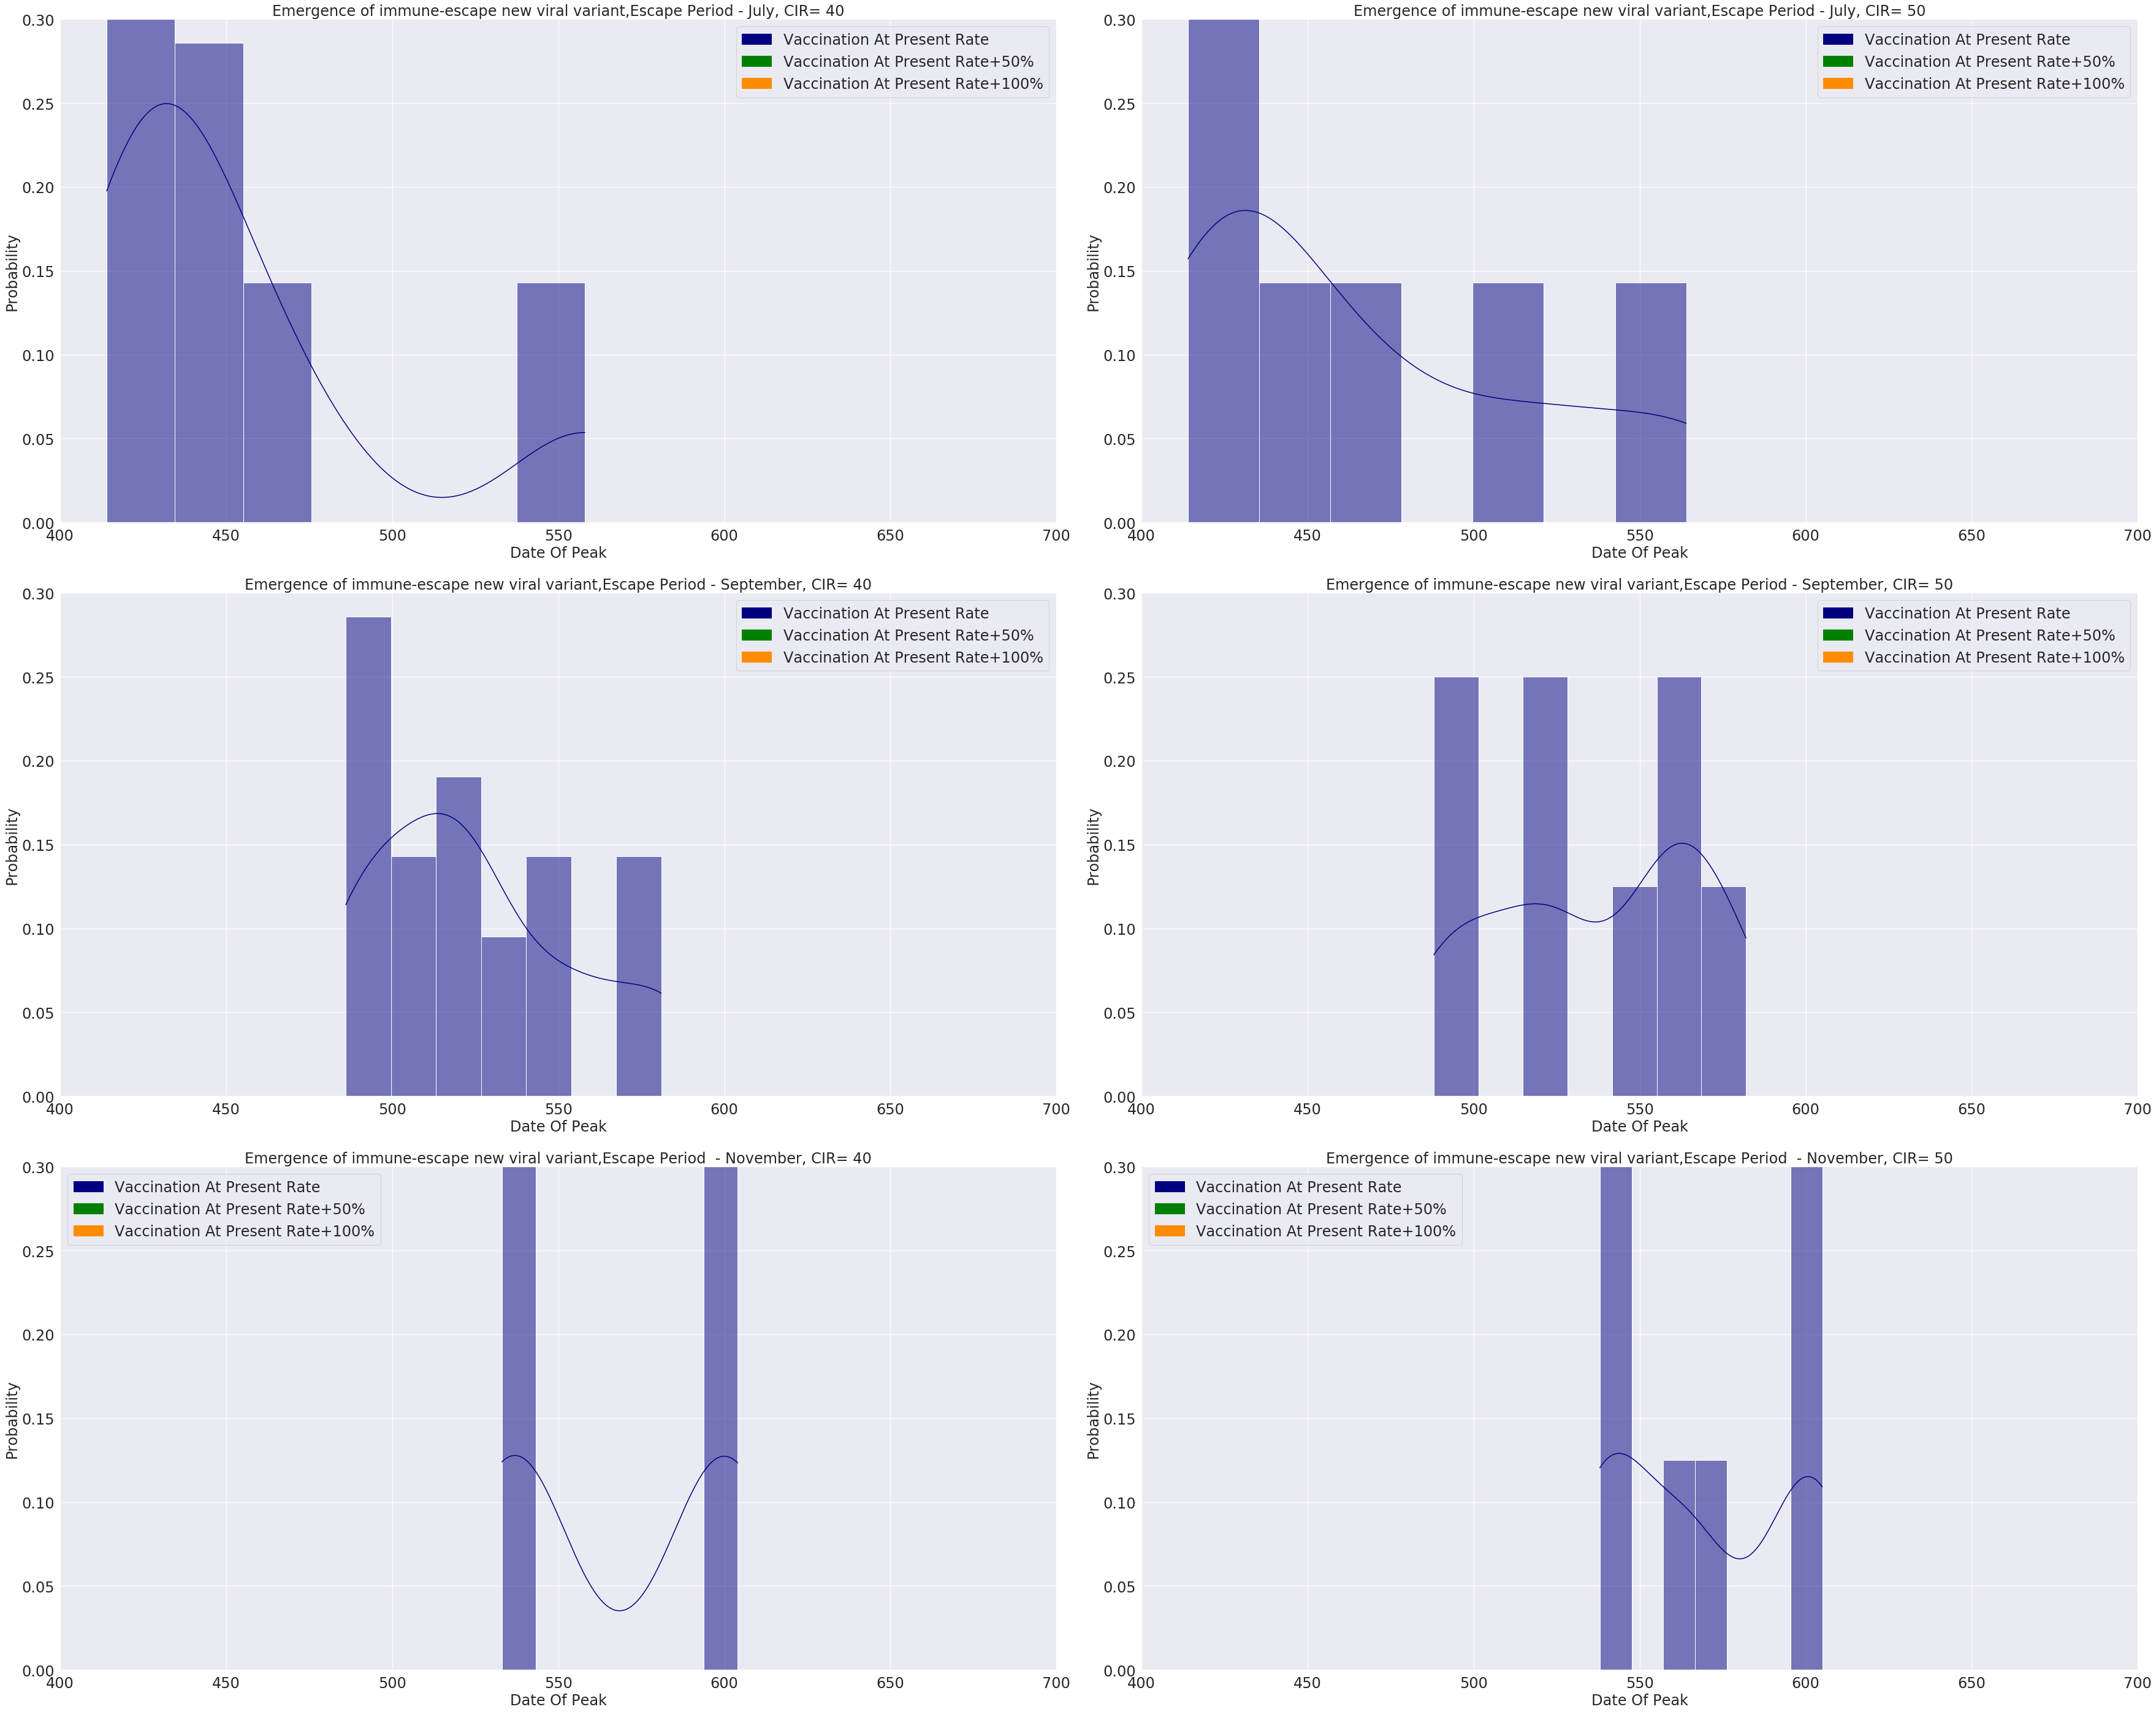

In [539]:
from scipy.stats import norm
import numpy
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
import matplotlib.patches as mpatches
fig, ax = plt.subplots(3,2,figsize=(50,40))
fig.tight_layout(pad=3.0)





colors = ['navy', 'green', 'darkorange']
kernel = 'epanechnikov'
KDPCIR=["CIR= 40", "CIR= 50"]
KDPImm=["Emergence of immune-escape new viral variant,Escape Period - July","Emergence of immune-escape new viral variant,Escape Period - September", "Emergence of immune-escape new viral variant,Escape Period  - November"]

#LinePLotVals = np.empty(shape=(4,4,4,200))

for i in range(3):
    for j in range(2):
        df_kde=df_active.copy(deep=True)
        df_kde=df_kde[df_kde['CIR']==KDP_nu_name[j]]
        df_kde=df_kde[df_kde['KDPwsat2']==KDP_w_sat_2_name[i]]
        df_kde.dropna(subset=['Date Of Peak'],inplace=True)
        a = [[] for x in range(k+1)]
        for k in range(1):
            df_kdep = df_kde.copy(deep=True)
            df_kdep = df_kdep[df_kdep['Vaccine Rate']==KDP_c_p_name[k]]
            
            hist = sns.histplot(ax=ax[i,j],data=df_kdep,x='Date Of Peak',stat='probability',kde=True,color=colors[k])
            
            #ll = hist.get_lines()[0].get_data()
            #LinePLotVals[i][j][k] = np.asarray(ll[1])
            #ax[i,j].containers[0].remove() # remove the bars
            #ax[i,j].relim() # the axis limits need to be recalculated without the bars
            #ax[i,j].autoscale_view()
            #ax[i,j].legend(loc='upper right')
            blue_patch=mpatches.Patch(color='navy',label='Vaccination At Present Rate')
            green_patch=mpatches.Patch(color='green',label='Vaccination At Present Rate+50%')
            orange_patch=mpatches.Patch(color='darkorange',label='Vaccination At Present Rate+100%')
            ax[i,j].legend(handles=[blue_patch,green_patch,orange_patch])
            ax[i,j].set_title(KDPImm[i]+", "+ KDPCIR[j])
            ax[i,j].set_xlabel("Date Of Peak")
            ax[i,j].set_xlim([400,700])
            ax[i,j].set_ylim([0,0.3])
            xt = []
            xtl = []

            nTicks = 10;

            dt = int(360/(nTicks + 1));

            for tickIndex in range(nTicks):
                xtl.append(date_generated[360 + tickIndex*dt]);
                xt.append(360 + tickIndex*dt);
                pass;

            axs[i,j].set_xticks(xt);
            axs[i,j].set_xticklabels(xtl);
            axs[i,j].tick_params(axis='x', rotation=60);
plt.show()



#fig, ax = plt.subplots(3,2,figsize=(50,30),sharex=True,sharey=True)
#fig.tight_layout(pad=3.0)

#for i in range(3):
#    for j in range(2):
#        for k in range(3):
#            sns.lineplot(ax=ax[i,j],data=LinePLotVals[i][j][k],label=KDP_c_p_name[k])
#            #ax[i,j].containers[0].remove() # remove the bars
#            #ax[i,j].relim() # the axis limits need to be recalculated without the bars
#            #ax[i,j].autoscale_view()
#            ax[i,j].legend(loc='upper right')
#            ax[i,j].set_title(KDPImm[i]+", "+ KDPCIR[j])
#            ax[i,j].set_xlabel("Number of cases at peak, in millions")
#plt.show()
        
import warnings
warnings.filterwarnings('ignore')

        
        

        



ValueError: Input passed into argument "'x'"is not 1-dimensional.

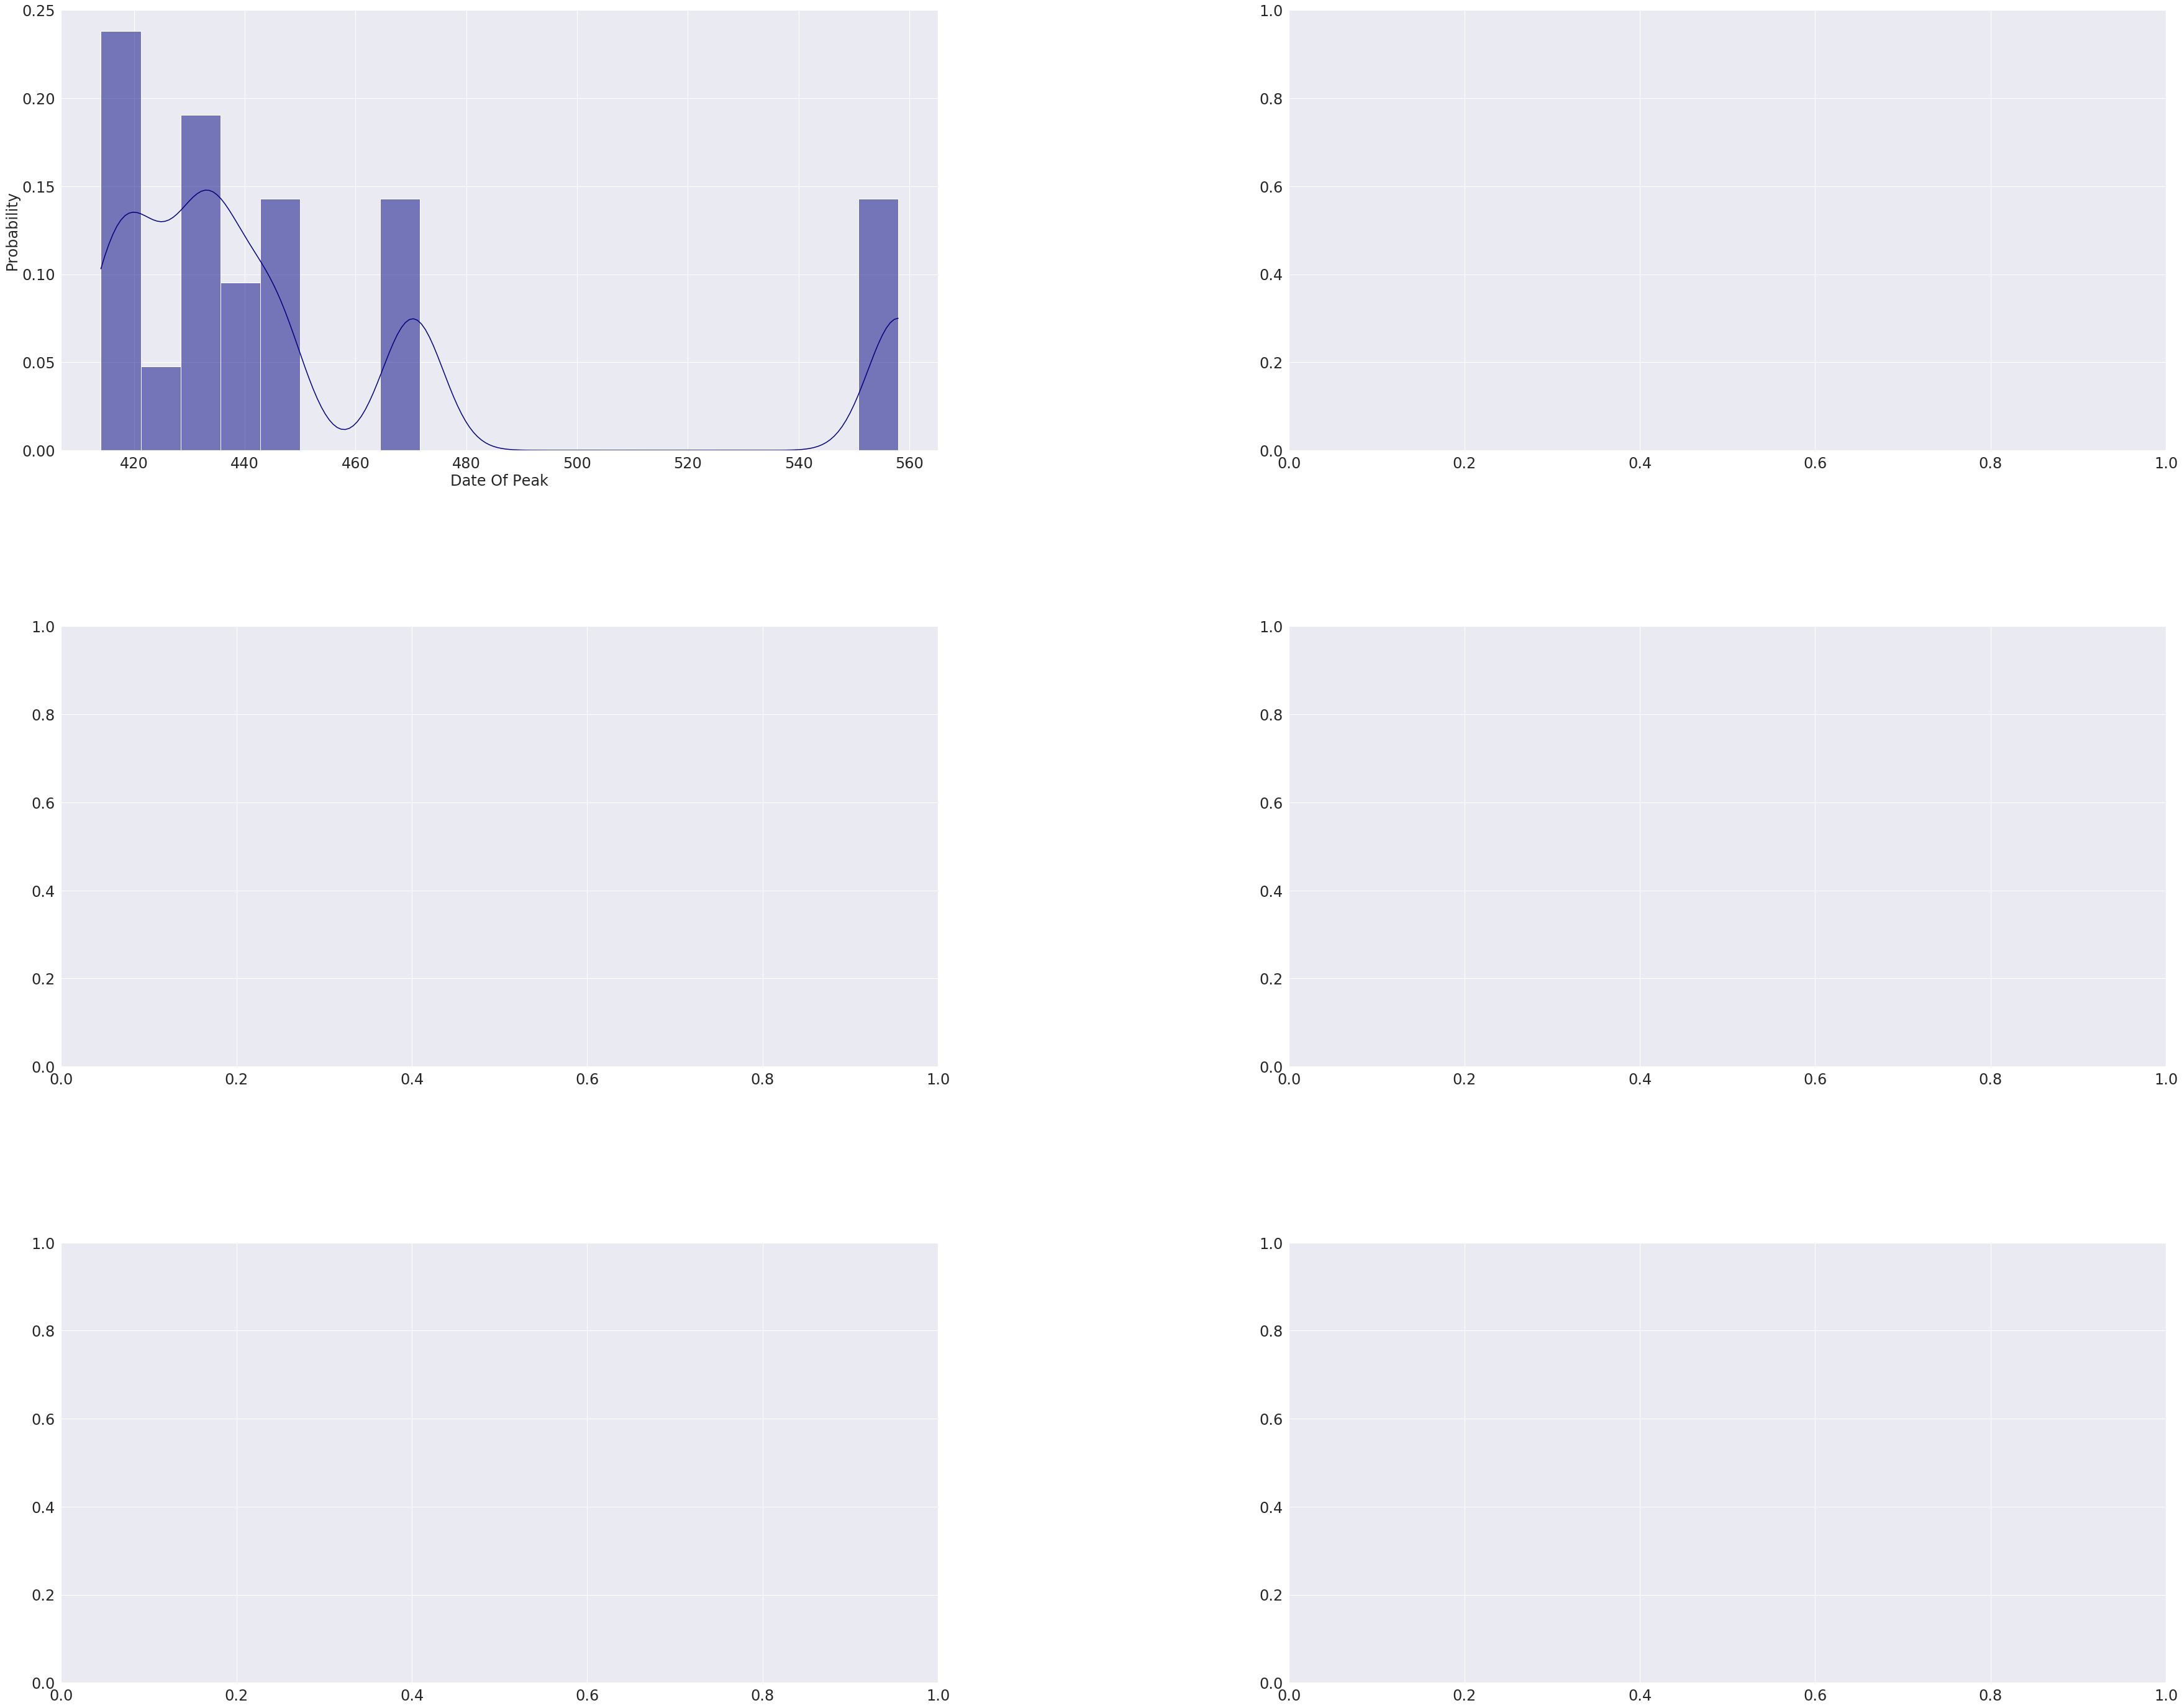

In [584]:
from scipy.stats import norm
import numpy
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
import matplotlib.patches as mpatches
fig, ax = plt.subplots(3,2,figsize=(50,40))
fig.tight_layout(pad=3.0)
plt.subplots_adjust(wspace=0.4,hspace=0.4)

start ="01/07/2020"
end  = "30/06/2022"

start = datetime.datetime.strptime(start, "%d/%m/%Y")
end = datetime.datetime.strptime(end, "%d/%m/%Y")
date_generated = [(start + datetime.timedelta(days=x)).date() for x in range(0, (end-start).days)]



colors = ['navy', 'green', 'darkorange']
kernel = 'epanechnikov'
KDPCIR=["CIR= 40", "CIR= 50"]
KDPImm=["Emergence of immune-escape new viral variant,Escape Period - July","Emergence of immune-escape new viral variant,Escape Period - September", "Emergence of immune-escape new viral variant,Escape Period  - November"]

#LinePLotVals = np.empty(shape=(4,4,4,200))

for i in range(3):
    for j in range(2):
        df_kde=df_active.copy(deep=True)
        df_kde=df_kde[df_kde['CIR']==KDP_nu_name[j]]
        df_kde=df_kde[df_kde['KDPwsat2']==KDP_w_sat_2_name[i]]
        df_kde.dropna(subset=['Date Of Peak'],inplace=True)
        a = [[] for x in range(k+1)]
        for k in range(3):
            df_kdep = df_kde.copy(deep=True)
            df_kdep = df_kdep[df_kdep['Vaccine Rate']==KDP_c_p_name[k]]
            
            hist = sns.histplot(ax=ax[i,j],data=df_kdep,x='Date Of Peak',stat='probability',kde=True,kde_kws={"bw_adjust":0.25},color=colors[k],bins=20)
            plt.fill_between(hist.get_lines()[0].get_data(),0)
            #ll = hist.get_lines()[0].get_data()
            #LinePLotVals[i][j][k] = np.asarray(ll[1])
            ax[i,j].containers[0].remove() # remove the bars
            #ax[i,j].relim() # the axis limits need to be recalculated without the bars
            #ax[i,j].autoscale_view()
            #ax[i,j].legend(loc='upper right')
            blue_patch=mpatches.Patch(color='navy',label='Vaccination At Present Rate')
            green_patch=mpatches.Patch(color='green',label='Vaccination At Present Rate+50%')
            orange_patch=mpatches.Patch(color='darkorange',label='Vaccination At Present Rate+100%')
            ax[i,j].legend(handles=[blue_patch,green_patch,orange_patch])
            ax[i,j].set_title(KDPImm[i]+", "+ KDPCIR[j])
            ax[i,j].set_xlabel("Date Of Peak")
            #ax[i,j].set_xlim([400,700])
            ax[i,j].set_ylim([0,0.4])
            
            
            xt = []
            xtl = []
        
            nTicks = 10;

            dt = int(360/(nTicks + 1));

            for tickIndex in range(nTicks):
                xtl.append(date_generated[360 + tickIndex*dt]);
                xt.append(360 + tickIndex*dt);
                pass;

            ax[i,j].set_xticks(xt);
            ax[i,j].set_xticklabels(xtl);
            ax[i,j].tick_params(axis='x', rotation=15);
plt.show()


#fig, ax = plt.subplots(3,2,figsize=(50,30),sharex=True,sharey=True)
#fig.tight_layout(pad=3.0)

#for i in range(3):
#    for j in range(2):
#        for k in range(3):
#            sns.lineplot(ax=ax[i,j],data=LinePLotVals[i][j][k],label=KDP_c_p_name[k])
#            #ax[i,j].containers[0].remove() # remove the bars
#            #ax[i,j].relim() # the axis limits need to be recalculated without the bars
#            #ax[i,j].autoscale_view()
#            ax[i,j].legend(loc='upper right')
#            ax[i,j].set_title(KDPImm[i]+", "+ KDPCIR[j])
#            ax[i,j].set_xlabel("Number of cases at peak, in millions")
#plt.show()
        
import warnings
warnings.filterwarnings('ignore')

        
        

        


In [241]:
kde

KernelDensity(bandwidth=0.5, kernel='epanechnikov')

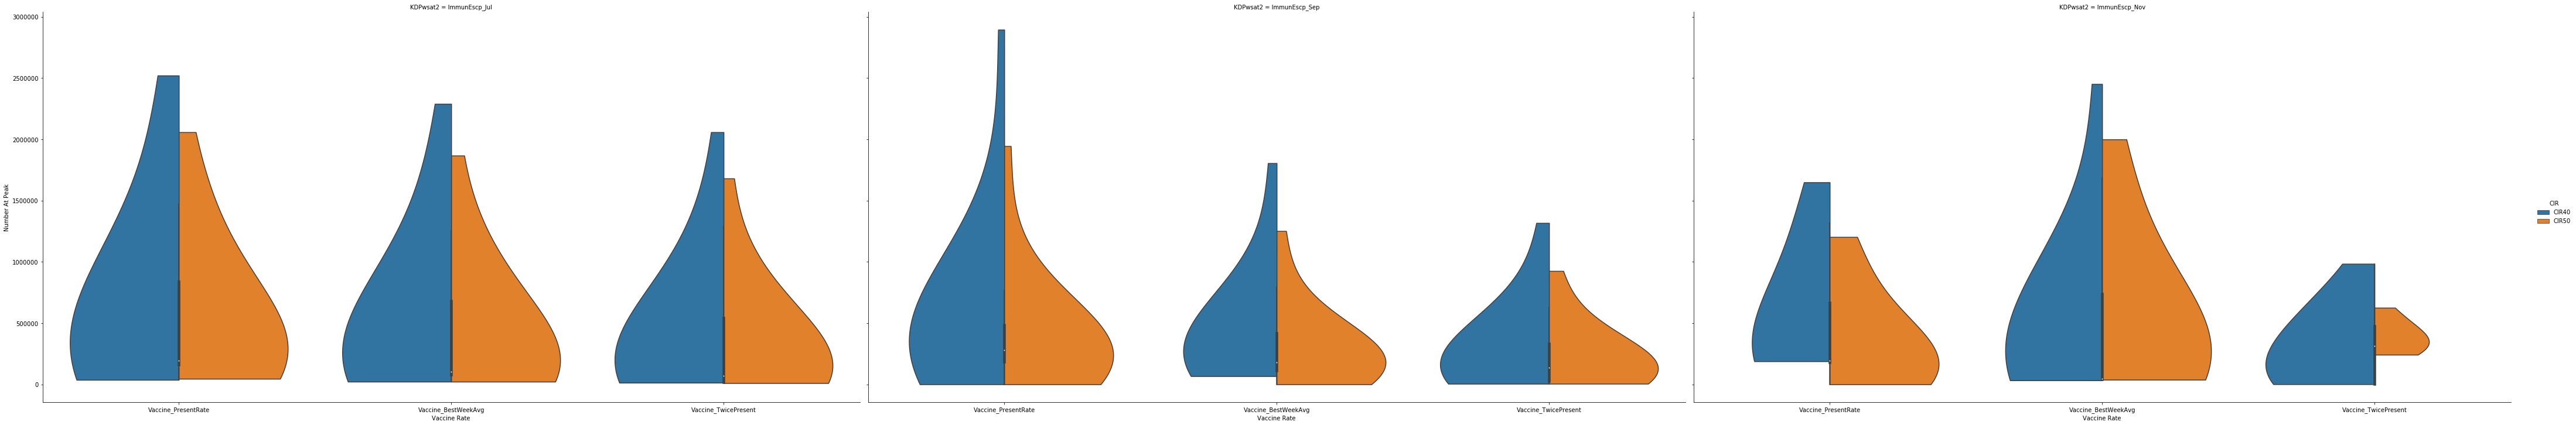

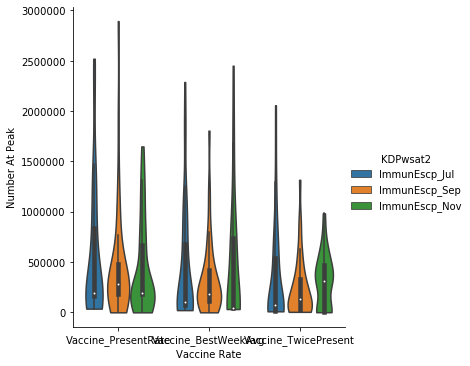

In [145]:


def plot_catplot(X,Y,df,hue,scale,cut,bandwidth):
    df_plot = df
    df_plot.dropna(subset=['Date Of Peak'],inplace=True)
    df_plot = df_plot.loc[df_plot[Y]< 3000000]
    #     sns.set(rc={​​​​​​​'figure.figsize':(15,10)}​​​​​​​)
    fig = sns.catplot(x=X, y=Y,
                hue=hue, col="KDPwsat2",data=df_plot,
                kind="violin", split=True,
                height=10, aspect=2,scale=scale,cut=cut,bw=bandwidth)
    sns.catplot(x="Vaccine Rate", y="Number At Peak", hue="KDPwsat2",

               data=df_plot, kind="violin",cut=0)
    


plot_catplot('Vaccine Rate','Number At Peak',df_active, 'CIR','count',0,1)


In [138]:
sns.catplot(x="Vaccine Rate", y="Number At Peak", hue="CIR",

               data=df_plot, kind="violin")

NameError: name 'df_plot' is not defined

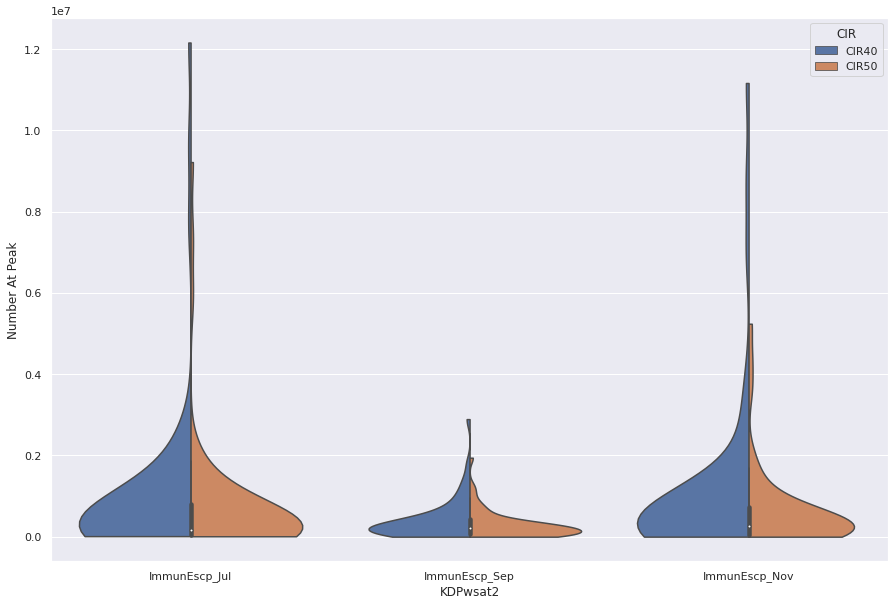

In [48]:
plot_violin('KDPwsat2','Number At Peak',df_active, 'CIR','count')


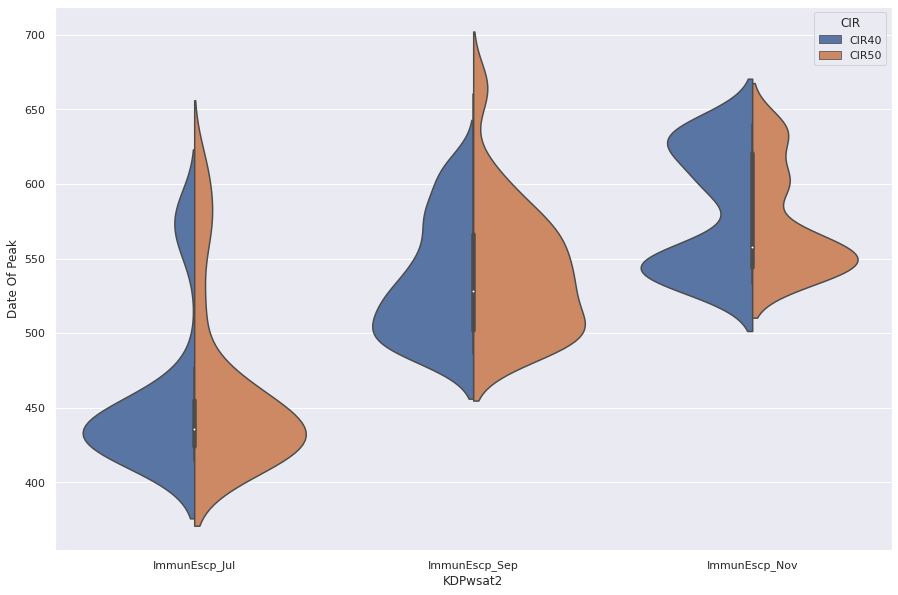

In [51]:
plot_violin('KDPwsat2','Date Of Peak',df_active, 'CIR','count')

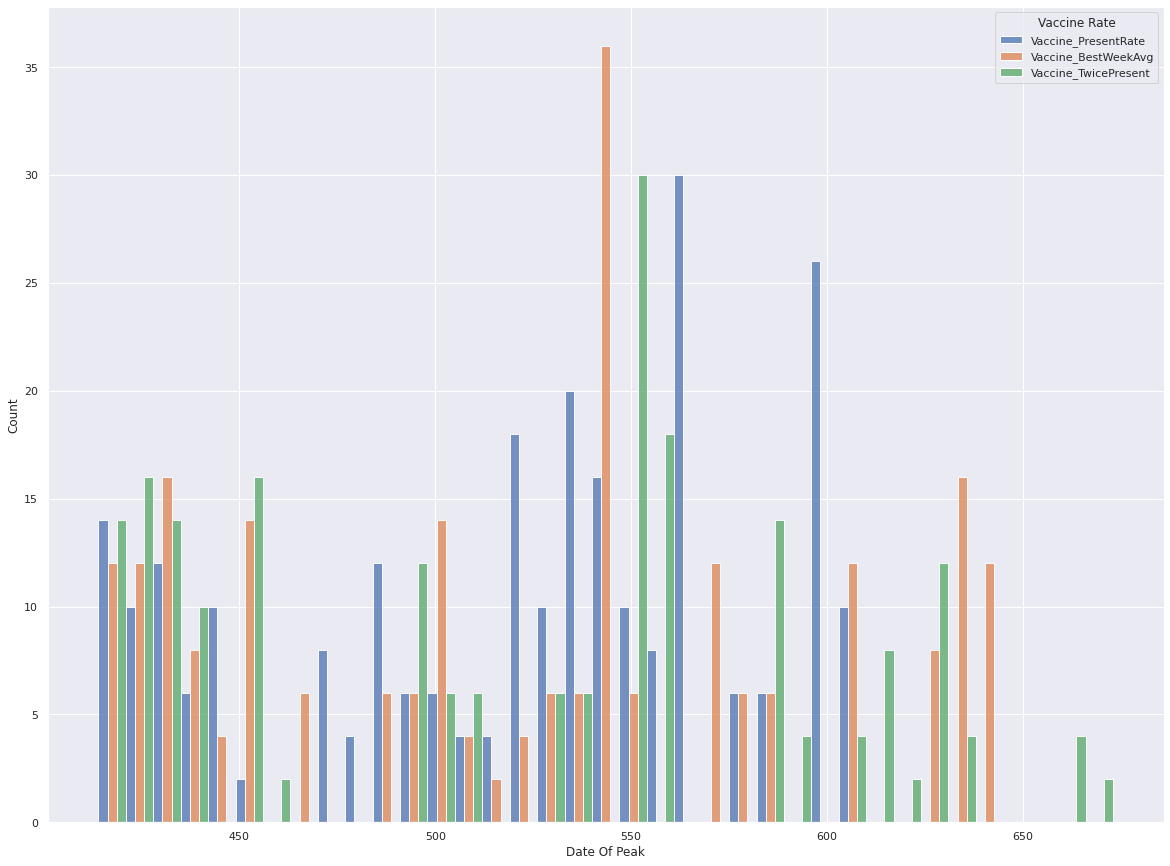

In [23]:
plot_histo(df_active,'Date Of Peak', 'Vaccine Rate', 7)

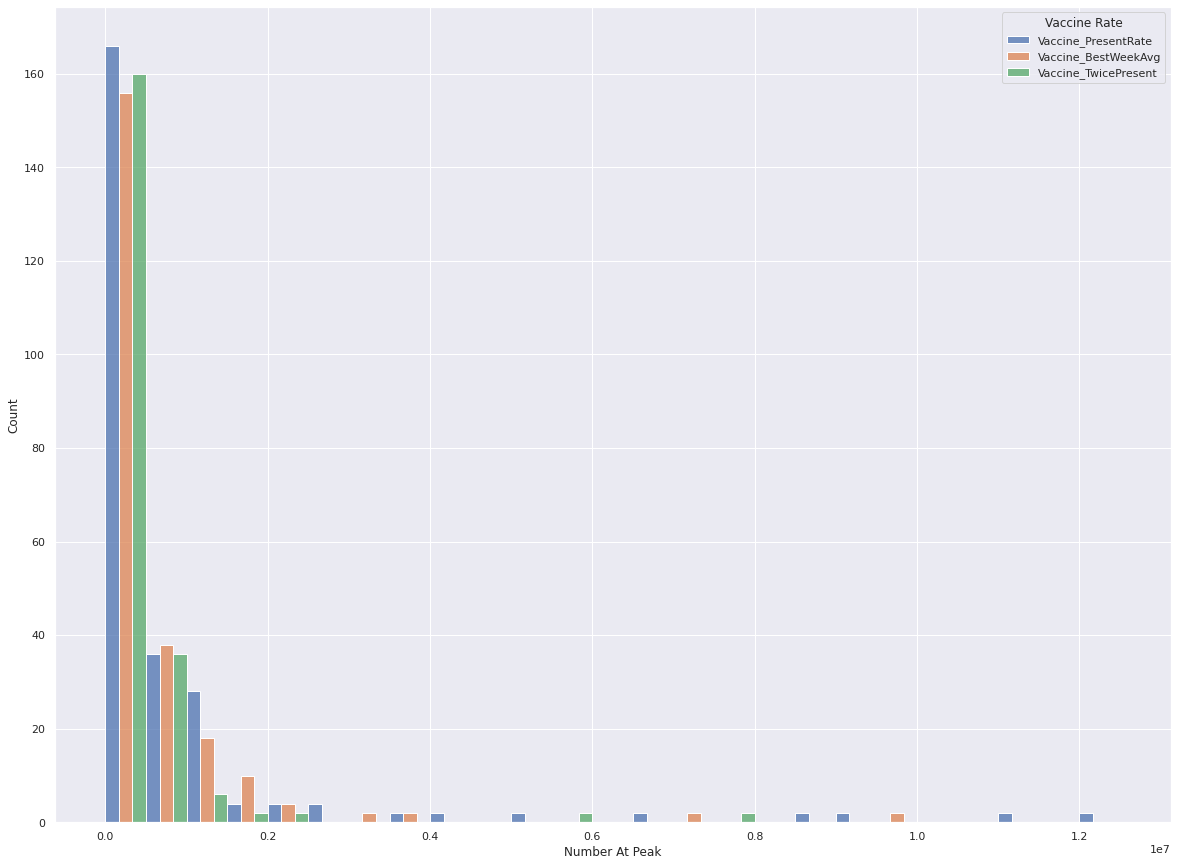

In [24]:
plot_histo(df_active,'Number At Peak','Vaccine Rate',5e5)

In [32]:
def AddMeanInfo(df):
    meanval = []
    minval = []
    maxval = []
    for i in range(731):
        meanval.append(np.mean(df[i]))
        minval.append(np.min(df[i]))
        maxval.append(np.max(df[i]))
    df.append(minval)
    df.append(maxval)
    df.append(meanval)
    
        
        
    

In [33]:
df_active = AddMeanInfo(df_active)

None
